<a href="https://colab.research.google.com/github/thiagoamaciel/intro-analise-dados/blob/master/tam2_IntroDescDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [0]:
# Nosso dados foram obtidos através do Kaggle, via o Banco Mundial. Ee representa a lista de Contratos de Serviços e Bens adquiridos 
# desde 2000 até os dias de hoje. Vamos tentar entender ciclos de crescimento e crises mundiais, e quais são os paises mais relevantes 
# em transacoes comerciais 
df = pd.read_csv("https://raw.githubusercontent.com/thiagoamaciel/intro-analise-dados/master/major-contract-awards.csv")

In [195]:
# como são os dados?
df.head(3)

,As of Date,Fiscal Year,Region,Borrower Country,Borrower Country Code,Project ID,Project Name,Procurement Type,Procurement Category,Procurement Method,Product line,Major Sector,WB Contract Number,Contract Description,Contract Signing Date,Supplier,Supplier Country,Supplier Country Code,Total Contract Amount (USD),Borrower Contract Reference Number,Main Loan or Credit
0,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Financial Sector,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,2000-11-20T00:00:00.000,KPMG INTERNATIONAL,United Kingdom,GB,-1600000.00,KPMG - 11/20/2000,NaN
1,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Public Admin,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,2000-11-20T00:00:00.000,KPMG INTERNATIONAL,United Kingdom,GB,3200000.00,KPMG - 11/20/2000,NaN
2,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000306,BF-Ouaga Water Suply (FY01),Preinvestment Activity,CONSULTANT SERVICES,Single Source Selection,IBRD/IDA,Water/Sanit/Waste,1117305,CONSULTANT SERVICES FOR CONTRACTS PREPARATION,1999-06-28T00:00:00.000,ICEA,France,FR,162643.21,18/ONEA/99,NaN


In [196]:
# estamos falando de quantos dados inicialmente?
nRow, nCol = df.shape
print(f'Existem {nRow} linhas e {nCol} colunas')

Existem 241223 linhas e 21 colunas


In [197]:
# Entendendo os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241223 entries, 0 to 241222
Data columns (total 21 columns):
As of Date                            241223 non-null object
Fiscal Year                           241223 non-null int64
Region                                241223 non-null object
Borrower Country                      241223 non-null object
Borrower Country Code                 241213 non-null object
Project ID                            241223 non-null object
Project Name                          241223 non-null object
Procurement Type                      241223 non-null object
Procurement Category                  241223 non-null object
Procurement Method                    241223 non-null object
Product line                          241223 non-null object
Major Sector                          241223 non-null object
WB Contract Number                    241223 non-null int64
Contract Description                  241217 non-null object
Contract Signing Date                

In [198]:
                      # Definição dos tipos e padronizando nomes das colunas para fácil acesso e manipulação

# removendo espaço nos nomes das colunas para fácil referencia
df.columns = [c.replace(' ', '_') for c in df.columns]

# convertendo para lower
df.columns = map(str.lower, df.columns)

# renomeando a coluna total_contract_amount_(usd) para total_contract_amount
df = df.rename(columns={'total_contract_amount_(usd)' : 'total_contract_amount'})

# Transformando os campos que possuem data e em padrão brasileiro
df.contract_signing_date = df.contract_signing_date.astype('datetime64[ns]')
df.contract_signing_date = pd.to_datetime(df.contract_signing_date)
df.contract_signing_date = df.contract_signing_date.dt.strftime("%d/%m/%Y")

# agora convertendo todos as colunas do tipo object para category
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241223 entries, 0 to 241222
Data columns (total 21 columns):
as_of_date                            241223 non-null category
fiscal_year                           241223 non-null int64
region                                241223 non-null category
borrower_country                      241223 non-null category
borrower_country_code                 241213 non-null category
project_id                            241223 non-null category
project_name                          241223 non-null category
procurement_type                      241223 non-null category
procurement_category                  241223 non-null category
procurement_method                    241223 non-null category
product_line                          241223 non-null category
major_sector                          241223 non-null category
wb_contract_number                    241223 non-null int64
contract_description                  241217 non-null category
contract_sign

In [199]:
df.head(3)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number,main_loan_or_credit
0,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Financial Sector,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,20/11/2000,KPMG INTERNATIONAL,United Kingdom,GB,-1600000.00,KPMG - 11/20/2000,NaN
1,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Public Admin,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,20/11/2000,KPMG INTERNATIONAL,United Kingdom,GB,3200000.00,KPMG - 11/20/2000,NaN
2,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000306,BF-Ouaga Water Suply (FY01),Preinvestment Activity,CONSULTANT SERVICES,Single Source Selection,IBRD/IDA,Water/Sanit/Waste,1117305,CONSULTANT SERVICES FOR CONTRACTS PREPARATION,28/06/1999,ICEA,France,FR,162643.21,18/ONEA/99,NaN


In [200]:
#Existem valores de contrato negativos?
print("Contratos negativos ou nulos:" + str((df.total_contract_amount <=0).sum()) + "\n" + 
      "Contratos positivos:" + str((df.total_contract_amount > 0).sum()))

Contratos negativos ou nulos:31503
Contratos positivos:209720


In [201]:
#Os contratos com valores negativos ou de valor igual a 0 não interessam para a nossa análise, dentro do nosso conhecimento do negócios, 
#são dados sujos e não representam a realidade 
df = df.drop(df.index[df.total_contract_amount <= 0])
df.head(3)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number,main_loan_or_credit
1,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Public Admin,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,20/11/2000,KPMG INTERNATIONAL,United Kingdom,GB,3200000.00,KPMG - 11/20/2000,NaN
2,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000306,BF-Ouaga Water Suply (FY01),Preinvestment Activity,CONSULTANT SERVICES,Single Source Selection,IBRD/IDA,Water/Sanit/Waste,1117305,CONSULTANT SERVICES FOR CONTRACTS PREPARATION,28/06/1999,ICEA,France,FR,162643.21,18/ONEA/99,NaN
3,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000276,TRANSPORT SECAL,"Equipment, Telecommunications",GOODS,International Competitive Bidding,IBRD/IDA,Public Admin,1119184,SUPPLY & INSTALLATION OF OPTIC CABLE BTWN ABID...,31/08/1999,CABLES PIRELLI S.A.,France,FR,4124340.34,139/SIT/IF/STS/BF/99,NaN


In [202]:
#Verificando se há valores NaN nas colunas
print(df.isnull().sum())

as_of_date                                 0
fiscal_year                                0
region                                     0
borrower_country                           0
borrower_country_code                      6
project_id                                 0
project_name                               0
procurement_type                           0
procurement_category                       0
procurement_method                         0
product_line                               0
major_sector                               0
wb_contract_number                         0
contract_description                       6
contract_signing_date                      0
supplier                                   1
supplier_country                           0
supplier_country_code                     14
total_contract_amount                      0
borrower_contract_reference_number       550
main_loan_or_credit                   209720
dtype: int64


In [203]:
# é possível observar que a coluna: main_loan_or_credit é irrelevante, pois todos boa parte de seus valores são nulos.
df = df.drop(columns="main_loan_or_credit")
df.head(3)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number
1,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Public Admin,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,20/11/2000,KPMG INTERNATIONAL,United Kingdom,GB,3200000.00,KPMG - 11/20/2000
2,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000306,BF-Ouaga Water Suply (FY01),Preinvestment Activity,CONSULTANT SERVICES,Single Source Selection,IBRD/IDA,Water/Sanit/Waste,1117305,CONSULTANT SERVICES FOR CONTRACTS PREPARATION,28/06/1999,ICEA,France,FR,162643.21,18/ONEA/99
3,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000276,TRANSPORT SECAL,"Equipment, Telecommunications",GOODS,International Competitive Bidding,IBRD/IDA,Public Admin,1119184,SUPPLY & INSTALLATION OF OPTIC CABLE BTWN ABID...,31/08/1999,CABLES PIRELLI S.A.,France,FR,4124340.34,139/SIT/IF/STS/BF/99


In [204]:
                    # Quais são os maiores paises contratantes?
df_country_count = pd.DataFrame({'Country':df.borrower_country.value_counts().index, 
                             'Count':df.borrower_country.value_counts().values})

data = [ dict(
        type = 'choropleth',
        locations = df_country_count['Country'],
        locationmode = 'country names',
        z = df_country_count['Count'],
        colorscale=
            [[0.0, "rgb(251, 237, 235)"],
            [0.09, "rgb(245, 211, 206)"],
            [0.12, "rgb(239, 179, 171)"],
            [0.15, "rgb(236, 148, 136)"],
            [0.22, "rgb(239, 117, 100)"],
            [0.35, "rgb(235, 90, 70)"],
            [0.45, "rgb(207, 81, 61)"],
            [0.65, "rgb(176, 70, 50)"],
            [0.85, "rgb(147, 59, 39)"],
            [1.00, "rgb(110, 47, 26)"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) 
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Paises Contratantes'),
      ) ]

layout = dict(
    title = "Distribuição de Paises Contratantes",
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(type = 'Mercator'),
        width=500,height=400)
)

w_map = dict( data=data, layout=layout)
iplot( w_map, validate=False)


In [205]:
                  # Foi visto acima que os países com maiores transações contratantes são: China, India, Brasil, Russia e Argentina
                  # Agora vem a pergunta: Quais são os maiores paises Fornecedores?
df_country_count = pd.DataFrame({'Country':df.supplier_country.value_counts().index, 
                             'Count':df.supplier_country.value_counts().values})

data = [ dict(
        type = 'choropleth',
        locations = df_country_count['Country'],
        locationmode = 'country names',
        z = df_country_count['Count'],
        colorscale=
            [[0.0, "rgb(251, 237, 235)"],
            [0.09, "rgb(245, 211, 206)"],
            [0.12, "rgb(239, 179, 171)"],
            [0.15, "rgb(236, 148, 136)"],
            [0.22, "rgb(239, 117, 100)"],
            [0.35, "rgb(235, 90, 70)"],
            [0.45, "rgb(207, 81, 61)"],
            [0.65, "rgb(176, 70, 50)"],
            [0.85, "rgb(147, 59, 39)"],
            [1.00, "rgb(110, 47, 26)"]],
        autocolorscale = False,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) 
        ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Paises Fornecedores'),
      ) ]

layout = dict(
    title = "Distribuição de Paises Fornecedores",
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(type = 'Mercator'),
        width=500,height=400)
)

w_map = dict( data=data, layout=layout)
iplot( w_map, validate=False)

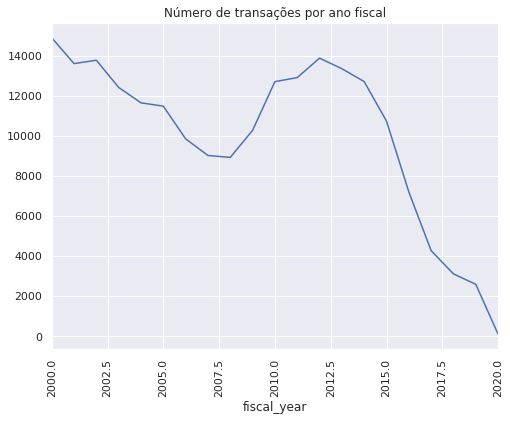

In [206]:
# Vamos plotar o número de transações por ano fiscal e tentar entender os ciclos economicos mundiais.
# É possível observar dois cliclos: 2008 (crise mundial) e 2012(inicio das quedas dos preços das commodities devido a China não impulsionar 
# o mercado mundial)
# https://economia.uol.com.br/noticias/redacao/2016/02/27/entenda-o-que-causou-a-crise-financeira-de-2008.htm
# https://www.bbc.com/portuguese/noticias/2013/05/130520_commodities_queda_crescimento_america_latina_lgb
fig = plt.figure(figsize=(8,6))
se = df.groupby('fiscal_year')['fiscal_year'].count()
se.plot()
plt.title("Número de transações por ano fiscal")
plt.xticks(rotation=90)
plt.show()

In [219]:
# Discretizando a coluna total_contract_amount. Como são valores muito altos dividimos, cada valor, por 1mm, e então discretizamos em 
# 10 intervalos iguais
#Possível perceber que grande parte dos contratos é de até 195mm de dólares
df['total_contract_amount_dist'] = pd.cut(df.total_contract_amount/1000000,10)
df.total_contract_amount_dist.value_counts()

#obs: não conseguimos entender o motivo do intervalo possuir valor negativo dado que esta coluna não possui mais valores <=0

(-1.101, 110.067]      209563
(110.067, 220.134]        110
(220.134, 330.201]         22
(330.201, 440.268]         11
(550.335, 660.402]          5
(770.469, 880.536]          4
(440.268, 550.335]          2
(990.602, 1100.669]         1
(880.536, 990.602]          1
(660.402, 770.469]          0
Name: total_contract_amount_dist, dtype: int64

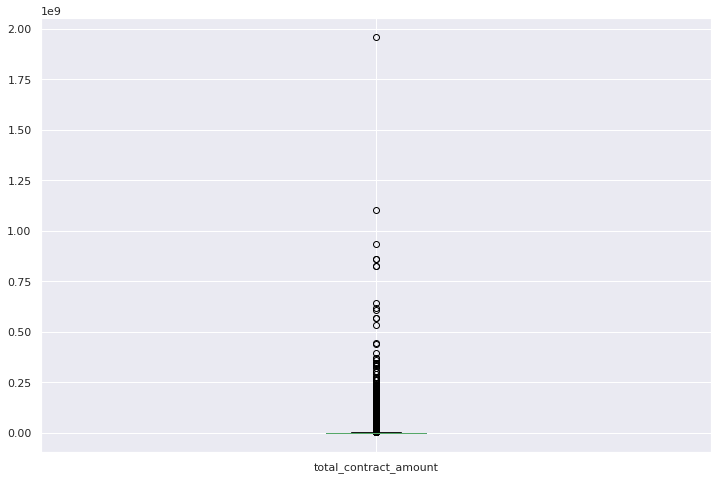

In [209]:
# Nos dados discretizados acima foi possível perceber contrato com valores na casa de bilhão. Também possível observar através do gráfico box, 
# abaixo:
df['total_contract_amount'].plot(
    kind='box',
    figsize=(12,8)
)

In [216]:
# Vamos entender quem seria esse contrato, pois há uma forte suspeita de dado outlier.
df[df['total_contract_amount'] >= 1500000000].head(4)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number,total_contract_amount_dist
143609,2019-08-07T00:00:00.000,2009,AFR,"Congo, Democratic Republic of",ZR,P082516,ZR-Multisectoral HIV/AIDS (FY04),"Pharmaceuticals, Medical Products",GOODS,Direct Selection,IBRD/IDA,(H)Health & social,1296546,Association de Sante Familiale - ASF,24/03/2009,ASSOCIATION DE SANTE FAMILIALE (ASF),"Congo, Democratic Republic of",ZR,1.956748e+09,N*013/CN-PNMLS/MAL/2007,"(1761.073, 1956.748]"


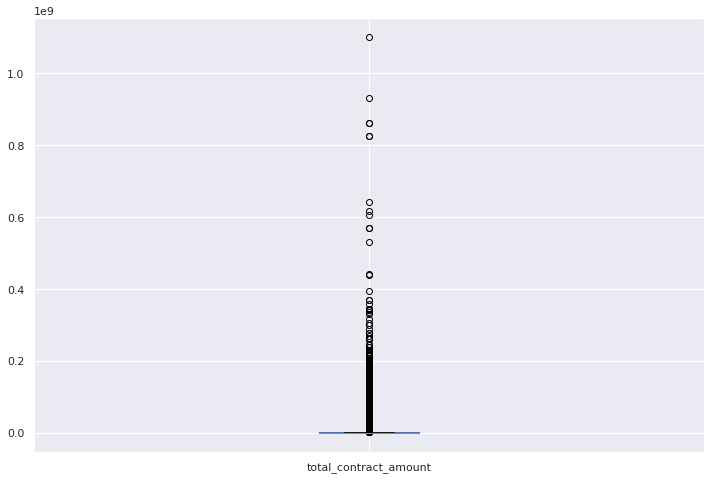

In [218]:
# Não parece que o contrato acima seja confiável dado que o pais contratante e o fornecedor é o mesmo. O fornecedor é uma associação, e que 
# muito provável quem forneceu o dinheiro foi o governo do Congo. Seria lavagem de dinheiro? 
# Não parece ser dado interessante para nossa análise
df = df.drop(df.index[df.total_contract_amount >= 1500000000])
df['total_contract_amount'].plot(
    kind='box',
    figsize=(12,8)
)

In [220]:
#skewness and kurtosis
print("Skewness: %f" % df['total_contract_amount'].skew())
print("Kurtosis: %f" % df['total_contract_amount'].kurt())

Skewness: 50.470078
Kurtosis: 4162.032832


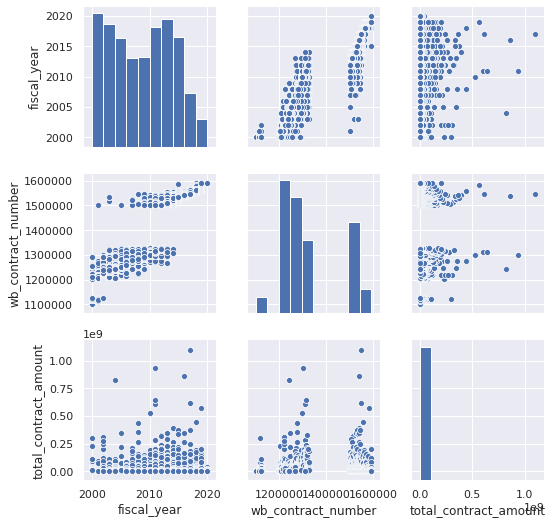

In [222]:
#Analisando estatisticas mais relevantes via a biblioteca seaborn
#O insight interessante dessa análise é que não é possível verificar os valores dos contratos de maiores relevâncias
sns.set()
sns.pairplot(df, height = 2.5)
plt.show();

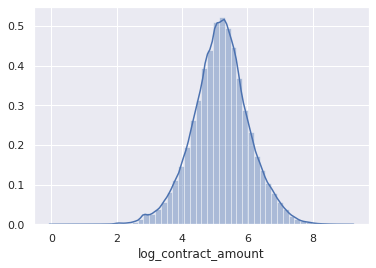

In [223]:
# Sendo assim é necessário normalizar tais dados
#Cria uma coluna nova log_contract com o objetivo de determinar sua respectiva relevância
df['log_contract_amount'] = df.total_contract_amount.apply(np.log10)
sns.distplot(df[df['log_contract_amount'] > 0]['log_contract_amount'])
#df[df['log_contract_amount'] > 0]['log_contract_amount'].hist()

In [224]:
#Através do gráfico há um compreendimento que os contratos mais relevantes são superiores a 6 e a maioria dos contratos estão entre 4 e 6
#É possível observar pela análise abaixo também
df[df['log_contract_amount'] > 0]['log_contract_amount'].describe()

count    209678.000000
mean          5.183132
std           0.865166
min           0.149219
25%           4.652059
50%           5.190423
75%           5.714117
max           9.041657
Name: log_contract_amount, dtype: float64

In [227]:
#Sendo assim, vamos definir uma coluna com a informação contratos Relevantes = (S/N)
df['relevante'] = 'S'
df.loc[(df['log_contract_amount'] < 6),'relevante'] = 'N'
df.head(3)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number,total_contract_amount_dist,log_contract_amount,relevante
1,2019-08-07T00:00:00.000,2000,AFR,Angola,AO,P000044,FINANCIAL INSTITUTIO,Implementation Activity,CONSULTANT SERVICES,Quality And Cost-Based Selection,IBRD/IDA,Public Admin,1207736,OIL SECTOR STUDY - CONTRCT WITH KPMG,20/11/2000,KPMG INTERNATIONAL,United Kingdom,GB,3200000.00,KPMG - 11/20/2000,"(-1.101, 110.067]",6.505150,S
2,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000306,BF-Ouaga Water Suply (FY01),Preinvestment Activity,CONSULTANT SERVICES,Single Source Selection,IBRD/IDA,Water/Sanit/Waste,1117305,CONSULTANT SERVICES FOR CONTRACTS PREPARATION,28/06/1999,ICEA,France,FR,162643.21,18/ONEA/99,"(-1.101, 110.067]",5.211236,N
3,2019-08-07T00:00:00.000,2000,AFR,Burkina Faso,BF,P000276,TRANSPORT SECAL,"Equipment, Telecommunications",GOODS,International Competitive Bidding,IBRD/IDA,Public Admin,1119184,SUPPLY & INSTALLATION OF OPTIC CABLE BTWN ABID...,31/08/1999,CABLES PIRELLI S.A.,France,FR,4124340.34,139/SIT/IF/STS/BF/99,"(-1.101, 110.067]",6.615354,S


In [240]:
#Concluimos que ao longo do períodos os paises os contratos mais relevantes foi India, China e Brasil
df[df['relevante'] == 'S'].groupby('borrower_country').sum().sort_values('total_contract_amount',ascending=False).total_contract_amount

borrower_country
India                           2.690023e+10
China                           2.628444e+10
Brazil                          1.110119e+10
Argentina                       9.353268e+09
Egypt, Arab Republic of         6.429490e+09
                                    ...     
Suriname                        0.000000e+00
Syrian Arab Republic            0.000000e+00
Caucasus                        0.000000e+00
Palau                           0.000000e+00
Middle East and North Africa    0.000000e+00
Name: total_contract_amount, Length: 176, dtype: float64

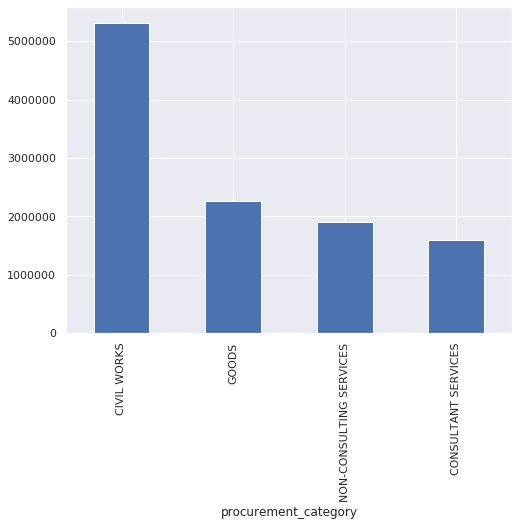

In [244]:
#Particularizando a China, dos contratos mais relevantes, o investimento maior é em Obras Civis
df[(df['relevante'] == 'S') & (df['borrower_country'] == 'China')].groupby('procurement_category')['total_contract_amount'].median().sort_values(ascending=False).plot.bar(figsize=(8,6))

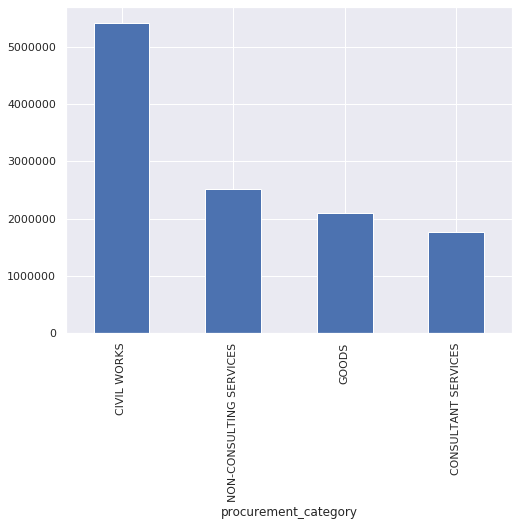

In [245]:
#Pelos dados coletados no Brazil tambem acontece isto, inverte a segunda e terceira posições.
df[(df['relevante'] == 'S') & (df['borrower_country'] == 'Brazil')].groupby('procurement_category')['total_contract_amount'].median().sort_values(ascending=False).plot.bar(figsize=(8,6))

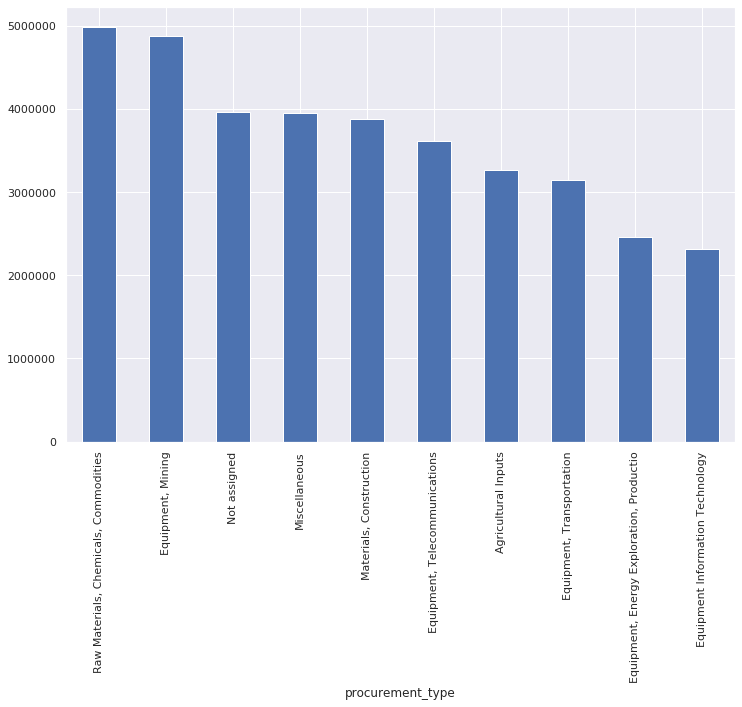

In [249]:
#Dentro do Segmento Bens, em que grupo de categoria foi mais investido
df[(df['procurement_category'] == 'GOODS') & (df['borrower_country'] == 'China') & (df['relevante'] == 'S')].groupby('procurement_type')['total_contract_amount'].median().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8))

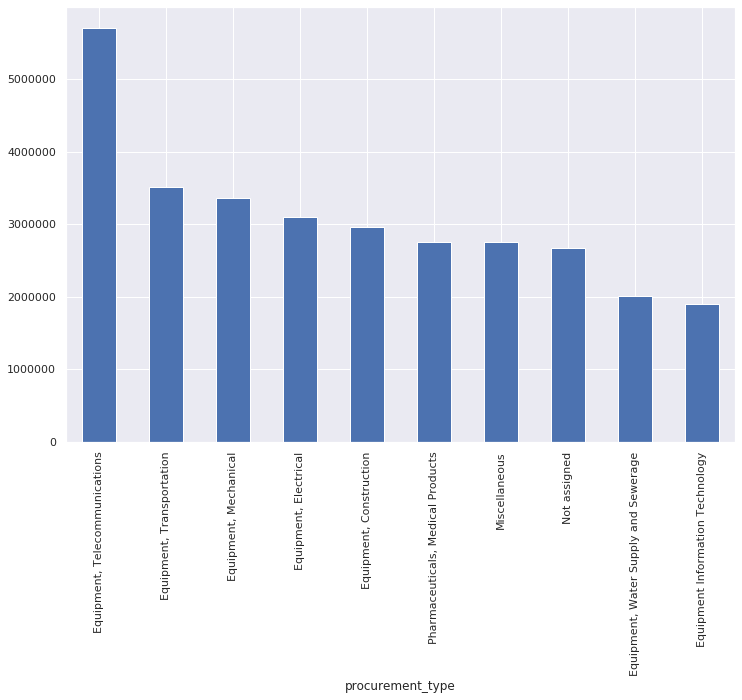

In [261]:
#Dentro do Segmento Bens, em que grupo de categoria foi mais investido
df[(df['procurement_category'] == 'GOODS') & (df['borrower_country'] == 'Brazil') & (df['relevante'] == 'S')].groupby('procurement_type')['total_contract_amount'].median().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8))

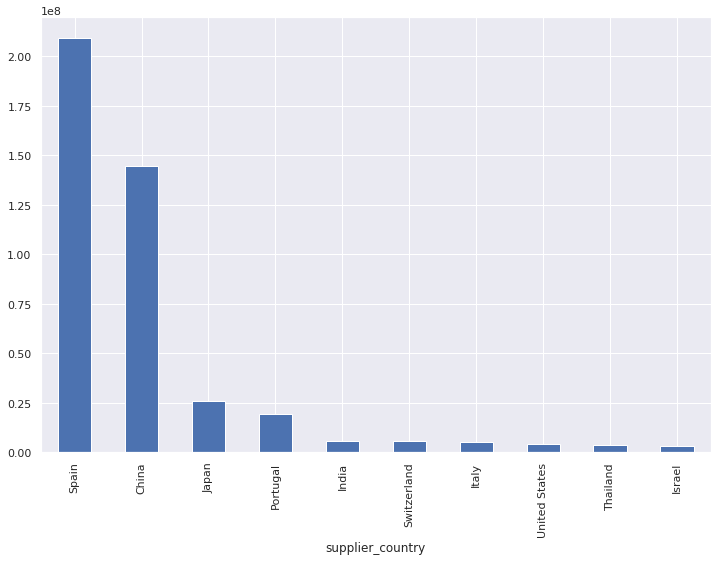

In [262]:
# Qual pais mais forneceu bens, em contratos relevantes, para o Brasil ao longo dos anos?
df[(df['procurement_category'] == 'GOODS') & (df['borrower_country'] == 'Brazil') & (df['relevante'] == 'S')].groupby('supplier_country')['total_contract_amount'].median().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8))

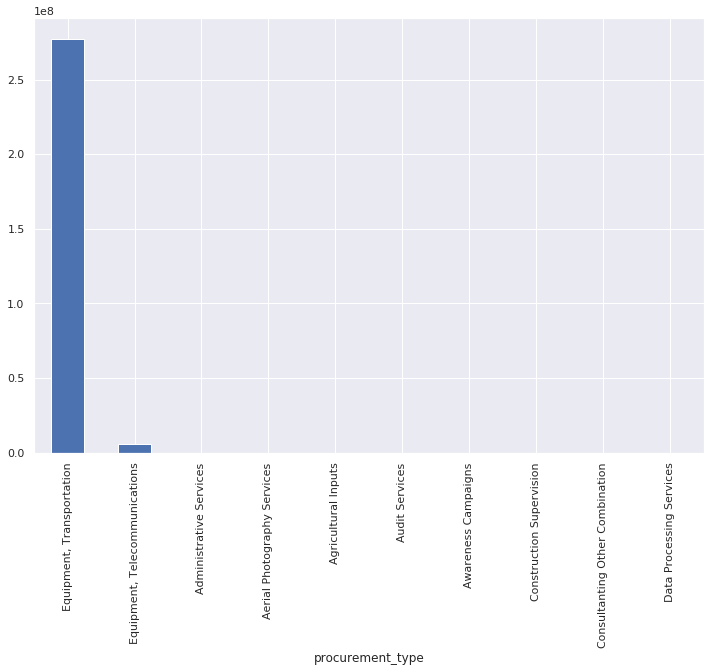

In [263]:
# Que tipo de bens a Espanha forneceu ao Brasil?
df[(df['procurement_category'] == 'GOODS') & (df['borrower_country'] == 'Brazil') & (df['relevante'] == 'S') & (df['supplier_country'] == 'Spain')].groupby('procurement_type')['total_contract_amount'].median().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8))

In [264]:
# Para quais tipos de projeto?
df[(df['procurement_category'] == 'GOODS') & (df['borrower_country'] == 'Brazil') & (df['relevante'] == 'S') & (df['supplier_country'] == 'Spain')].head(10)

,as_of_date,fiscal_year,region,borrower_country,borrower_country_code,project_id,project_name,procurement_type,procurement_category,procurement_method,product_line,major_sector,wb_contract_number,contract_description,contract_signing_date,supplier,supplier_country,supplier_country_code,total_contract_amount,borrower_contract_reference_number,total_contract_amount_dist,log_contract_amount,relevante
98546,2019-08-07T00:00:00.000,2005,LCR,Brazil,BR,P048869,BR SALVADOR URBAN TRANS,"Equipment, Telecommunications",GOODS,International Competitive Bidding,IBRD/IDA,Transportation,1266602,"SUPPLY AND INSTALLATION OF SIGNALLING, TRAFFIC...",22/12/2004,BOMBARDIER TRANSP. SPAIN,Spain,ES,5.813110e+06,SA-12 (10/04-CTS)/CONSORCIO BOMF,"(-1.101, 110.067]",6.764409,S
132812,2019-08-07T00:00:00.000,2008,LCR,Brazil,BR,P106038,BR Sao Paulo Trains and Signalling,"Equipment, Transportation",GOODS,International Competitive Bidding,IBRD/IDA,Transportation,1276632,SUPPLY OF 17-TRAINS WITH 6 CARS EACH,03/07/2008,CAF-CONSTRUCCIONES Y AUXILIAR DE FERROCARRILES...,Spain,ES,1.410202e+08,4125721201,"(110.067, 220.134]",8.149281,S
134820,2019-08-07T00:00:00.000,2008,LCR,Brazil,BR,P106038,BR Sao Paulo Trains and Signalling,"Equipment, Transportation",GOODS,International Competitive Bidding,IBRD/IDA,Transportation,1276636,SUPPLY OF 40 TRAINS WITH 8 CARS EACH FOR CPTM,03/07/2008,CAF-CONSTRUCCIONES Y AUXILIAR DE FERROCARRILES...,Spain,ES,3.581014e+08,STM/002/2008 & STM009/2008,"(330.201, 440.268]",8.554006,S
171833,2019-08-07T00:00:00.000,2011,LCR,Brazil,BR,P116170,BR Sao Paulo Metro Line 5,"Equipment, Transportation",GOODS,International Competitive Bidding,IBRD/IDA,Transportation,1310746,"Supply of 26 trains, with six cars each for Li...",12/07/2011,CAF-CONSTRUCCIONES Y AUXILIAR DE FERROCARRILES...,Spain,ES,2.773972e+08,NO. STM 006/2011 (4127821201),"(220.134, 330.201]",8.443102,S
